## Homework

In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`,
* `MSRP`

In [5]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv -O data_hwk.csv

--2023-10-11 15:30:19--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: 'data_hwk.csv'

     0K .......... .......... .......... .......... ..........  3% 1.05M 1s
    50K .......... .......... .......... .......... ..........  6% 5.11M 1s
   100K .......... .......... .......... .......... .......... 10% 2.03M 1s
   150K .......... .......... .......... .......... .......... 13% 7.22M 1s
   200K .......... .......... .......... .......... .......... 17% 5.82M 0s
   250K .......... .......... .......... .......... .......... 20% 4.29M 0s
   300K .......... .......... .......... .......... .......... 24%

In [47]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

## Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [10]:
# Load data
df = pd.read_csv('data_hwk.csv')
# Keep only relevant columns
df = df[['Make', 'Model', 'Year', 'Engine HP',
        'Engine Cylinders', 'Transmission Type',
        'Vehicle Style', 'highway MPG', 'city mpg',
        'MSRP']]
# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')
for c in df.dtypes[df.dtypes == 'object'].index:
    df[c] = df[c].str.lower().str.replace(' ', '_')
# Fill missing values with 0
df.fillna(0, inplace=True)
# Get above average price flag
df['above_average'] = (df.msrp > df.msrp.mean()).astype(int)
df.drop(columns=['msrp'], inplace=True)
# Split data into 3 parts: train, validation, test (60%, 20%, 20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
# Get target variable
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values
# Drop target variable from datasets
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [31]:
# Auxiliar functions
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

# Get numeric & categorical columns
numeric_cols = list(df_train.dtypes[df_train.dtypes != 'object'].index)
categorical_cols = list(df_train.dtypes[df_train.dtypes == 'object'].index)
# Estimate AUC for different features
for col in numeric_cols:
    dv, model = train(df_train[[col]], y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    if auc < 0.5:
        print(col, 'Negative correlation detected')
        dv, model = train(-df_train[[col]], y_train, C=0.01)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)        
    print('AUC:', col, round(auc, 3))
# ANSWER: Engine HP

year Negative correlation detected
AUC: year 0.691
AUC: engine_hp 0.915
AUC: engine_cylinders 0.769
AUC: highway_mpg 0.629
AUC: city_mpg 0.67


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [33]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
print('AUC:', round(auc, 3))

AUC: 0.9801


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [41]:
def get_scores_df(y_val, y_pred):
    n = len(y_val)
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
    df_scores['accuracy'] = (df_scores.tp + df_scores.tn) / n
    
    return df_scores

df_scores = get_scores_df(y_val, y_pred)

threshold       0.480000
tp            583.000000
fp             74.000000
fn             71.000000
tn           1655.000000
precision       0.887367
recall          0.891437
f1_score        0.889397
accuracy        0.939152
Name: 48, dtype: float64

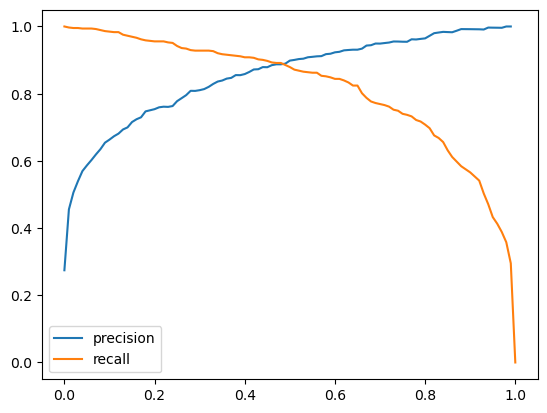

In [40]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

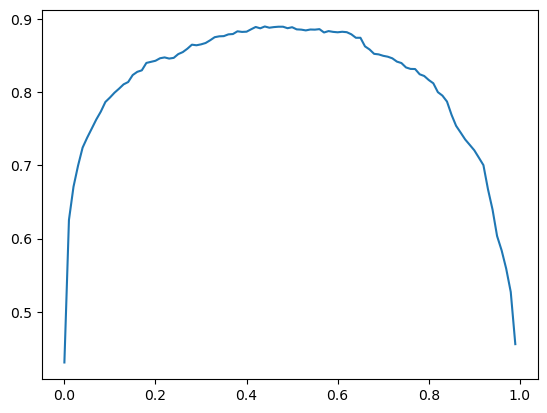

In [43]:
plt.plot(df_scores.threshold, df_scores.f1_score, label='f1_score')

In [46]:
df_scores.sort_values(by='f1_score', ascending=False).head(20)

,threshold,tp,fp,fn,tn,precision,recall,f1_score,accuracy
44,0.44,589,81,65,1648,0.879104,0.900612,0.889728,0.938733
48,0.48,583,74,71,1655,0.887367,0.891437,0.889397,0.939152
47,0.47,583,74,71,1655,0.887367,0.891437,0.889397,0.939152
42,0.42,593,87,61,1642,0.872059,0.906728,0.889055,0.937893
46,0.46,584,76,70,1653,0.884848,0.892966,0.888889,0.938733
50,0.50,575,65,79,1664,0.898438,0.879205,0.888717,0.939572
45,0.45,587,81,67,1648,0.878743,0.897554,0.888048,0.937893
49,0.49,579,72,75,1657,0.889401,0.885321,0.887356,0.938313
43,0.43,590,86,64,1643,0.872781,0.902141,0.887218,0.937054
56,0.56,564,55,90,1674,0.911147,0.862385,0.886096,0.939152


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140


In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    # Reset indexes
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    # Get target variable
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    # Drop target variable from datasets
    del df_train['above_average']
    del df_val['above_average']
    # Fit and predict
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    # Get AUC score
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC score=%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

AUC score=0.980 +- 0.003


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [51]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        # Reset indexes
        df_train = df_train.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)
        # Get target variable
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        # Drop target variable from datasets
        del df_train['above_average']
        del df_val['above_average']
        # Fit and predict
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        # Get AUC score
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.001
C=0.5 0.978 +- 0.001
C=10 0.983 +- 0.002
